# FIS Optimization Experiment: Genetic Algorithm

In [2]:
import sys
import os

current_dir = os.getcwd()

project_root = os.path.abspath(os.path.join(current_dir, '../'))

if project_root not in sys.path:
    sys.path.append(project_root)

In [3]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, classification_report

from optimizations.ga.ga import GAFISOptimizer
from fis.fis_model import FISChatbot

/tmp/ipykernel_22216/3161511034.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
DATA_DIR = os.path.join(project_root, "..", "data", "processed")

In [4]:
X_train = np.load(os.path.join(DATA_DIR, "X_train.npy"))
X_test = np.load(os.path.join(DATA_DIR, "X_test.npy"))
y_train = np.load(os.path.join(DATA_DIR, "y_train.npy"))
y_test = np.load(os.path.join(DATA_DIR, "y_test.npy"))

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape:  {X_test.shape}")
print(f"y_test shape:  {y_test.shape}")

X_train shape: (12800, 6)
y_train shape: (12800,)
X_test shape:  (3200, 6)
y_test shape:  (3200,)


In [5]:
# Cell: Run Experiments

N_EXPERIMENTS = 5       
POPULATION_SIZE = 20    
GENERATIONS = 30        
BATCH_SIZE = 200
EARLY_STOPPING = 10     # Stop if no improvement

results = []
all_histories = []

print(f"{'='*60}")
print(f"GA-FIS Optimization")
print(f"{'='*60}")
print(f"Config: {N_EXPERIMENTS} runs, Pop={POPULATION_SIZE}, Gen={GENERATIONS}")
print(f"Batch={BATCH_SIZE}, Early Stop={EARLY_STOPPING}")
print(f"{'='*60}\n")

for i in range(N_EXPERIMENTS):
    print(f"\n[Run {i+1}/{N_EXPERIMENTS}]")
    
    optimizer = GAFISOptimizer(X_train, y_train, batch_size=BATCH_SIZE)
    
    start_time = time.time()
    best_fitness = optimizer.run(
        num_generations=GENERATIONS, 
        population_size=POPULATION_SIZE,
        early_stopping_rounds=EARLY_STOPPING
    )
    exec_time = time.time() - start_time
    
    best_model = optimizer.get_optimized_model()
    y_pred_opt = best_model.predict_batch(X_test)
    
    acc = accuracy_score(y_test, y_pred_opt)
    f1 = f1_score(y_test, y_pred_opt, average='weighted')
    
    print(f"  >> Test Acc: {acc:.4f} | F1: {f1:.4f} | Time: {exec_time:.2f}s")
    
    results.append({
        "run_id": i + 1,
        "accuracy": acc,
        "f1_weighted": f1,
        "execution_time": exec_time,
        "best_fitness_train": best_fitness
    })
    all_histories.append(optimizer.get_history())

GA-FIS Optimization
Config: 5 runs, Pop=20, Gen=30
Batch=200, Early Stop=10


[Run 1/5]
  GA Config: Pop=20, Gen=30, Batch=200, Chromosome=18 genes
    Gen 5/30 | Best: 0.3586 | Avg: 0.3013
    Gen 10/30 | Best: 0.3788 | Avg: 0.3093
    Gen 15/30 | Best: 0.3838 | Avg: 0.3068
    Gen 20/30 | Best: 0.3838 | Avg: 0.2972
    Gen 25/30 | Best: 0.4192 | Avg: 0.3061
    Gen 30/30 | Best: 0.4192 | Avg: 0.3215
  GA Complete! Best Fitness: 0.4192
  >> Test Acc: 0.5091 | F1: 0.4475 | Time: 994.91s

[Run 2/5]
  GA Config: Pop=20, Gen=30, Batch=200, Chromosome=18 genes
    Gen 5/30 | Best: 0.3737 | Avg: 0.2942
    Gen 10/30 | Best: 0.3889 | Avg: 0.3003
    Gen 15/30 | Best: 0.3889 | Avg: 0.3051
    Early stopping at gen 19 (no improvement for 10 gens)
  GA Complete! Best Fitness: 0.3889
  >> Test Acc: 0.4913 | F1: 0.4338 | Time: 640.62s

[Run 3/5]
  GA Config: Pop=20, Gen=30, Batch=200, Chromosome=18 genes
    Gen 5/30 | Best: 0.3788 | Avg: 0.3030
    Gen 10/30 | Best: 0.3838 | Avg: 0.3056
    Gen 

In [14]:
df_results = pd.DataFrame(results)

In [15]:
df_results.sort_values(by='f1_weighted', ascending=False)

,run_id,accuracy,f1_weighted,execution_time,best_fitness_train
3,4,0.509062,0.449572,573.045822,0.383838
4,5,0.509062,0.449207,459.652227,0.404040
0,1,0.509062,0.447536,994.911885,0.419192
1,2,0.491250,0.433844,640.621485,0.388889
2,3,0.487187,0.430299,477.203022,0.383838


In [12]:
best_f1 = df_results["f1_weighted"].max()
print(f"Best F1 Weighted: {best_f1:.4f}")

Best F1 Weighted: 0.4496


In [16]:
total_time = df_results["execution_time"].sum()
print(f"Total Execution Time: {total_time:.2f}s ({total_time/60:.2f} minutes)")

Total Execution Time: 3145.43s (52.42 minutes)


In [17]:
best_acc = df_results["accuracy"].max()
best_run_idx = df_results["f1_weighted"].idxmax()
std_f1 = df_results["f1_weighted"].std()

print("=== GA Evaluation ===")
print(f"Akurasi              : {best_acc:.4f}")
print(f"F1-Score (weighted)  : {best_f1:.4f}")
print(f"Waktu Eksekusi       : {total_time:.4f} detik ({total_time/60:.2f} menit)")
print(f"Stabilitas(σ)        : {std_f1:.4f}")

=== GA Evaluation ===
Akurasi              : 0.5091
F1-Score (weighted)  : 0.4496
Waktu Eksekusi       : 3145.4344 detik (52.42 menit)
Stabilitas(σ)        : 0.0093


In [4]:
data_runs = [
    {
        "run_id": 1,
        "accuracy": 0.509062,
        "f1_weighted": 0.447536,
        "execution_time": 994.911885,
        "best_fitness_train": 0.419192
    },
    {
        "run_id": 2,
        "accuracy": 0.491250,
        "f1_weighted": 0.433844,
        "execution_time": 640.621485,
        "best_fitness_train": 0.388889
    },
    {
        "run_id": 3,
        "accuracy": 0.487187,
        "f1_weighted": 0.430299,
        "execution_time": 477.203022,
        "best_fitness_train": 0.383838
    },
    {
        "run_id": 4,
        "accuracy": 0.509062,
        "f1_weighted": 0.449572,
        "execution_time": 573.045822,
        "best_fitness_train": 0.383838
    },
    {
        "run_id": 5,
        "accuracy": 0.509062,
        "f1_weighted": 0.449207,
        "execution_time": 459.652227,
        "best_fitness_train": 0.404040
    },
]
df = pd.DataFrame(data_runs)

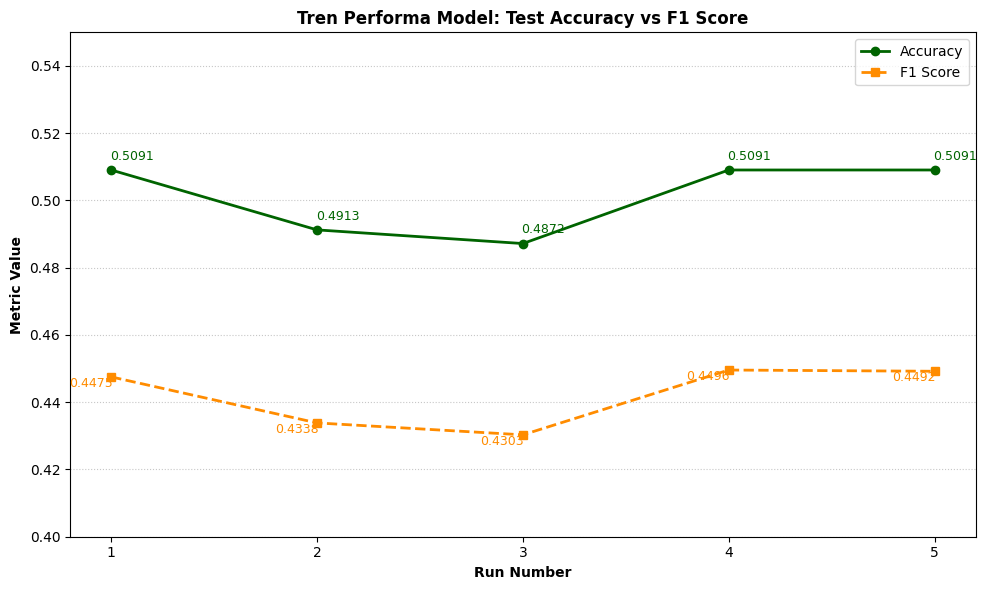

In [5]:
# Membuat Line Plot untuk menunjukkan tren Accuracy dan F1 Score
plt.figure(figsize=(10, 6))

# Plotting Accuracy
plt.plot(df['run_id'], df['accuracy'], marker='o', linestyle='-', color='darkgreen', linewidth=2, label='Accuracy')

# Plotting F1 Score
plt.plot(df['run_id'], df['f1_weighted'], marker='s', linestyle='--', color='darkorange', linewidth=2, label='F1 Score')

# Menambahkan label, judul, dan grid
plt.xlabel('Run Number', fontweight='bold')
plt.ylabel('Metric Value', fontweight='bold')
plt.title('Tren Performa Model: Test Accuracy vs F1 Score', fontweight='bold')
plt.xticks(df['run_id']) # Memastikan label x adalah bilangan bulat 1-5
plt.ylim(0.40, 0.55) # Mengatur batas y untuk fokus pada perbedaan

# Menambahkan nilai di atas titik data
for i in range(len(df)):
    plt.text(df['run_id'][i] + 0.1, df['accuracy'][i] + 0.003, f"{df['accuracy'][i]:.4f}", color='darkgreen', ha = 'center', fontsize=9)
    plt.text(df['run_id'][i] - 0.1, df['f1_weighted'][i] - 0.003, f"{df['f1_weighted'][i]:.4f}", color='darkorange', ha = 'center', fontsize=9)

plt.legend()
plt.grid(axis='y', linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()